## Importing Required Libraries

This cell imports the key libraries needed for distributed deep learning and image processing:

- `ray`: Enables scalable distributed computing for model training and data processing.
- `torch`: Core PyTorch package for building and training neural networks.
- `torchvision.models` and `torchvision.transforms`: Provides access to pretrained models (like ResNet152) and common image transformations.
- `PIL.Image`: Supports image loading and manipulation using the Pillow library.
- `numpy`: Essential package for efficient numerical operations and array manipulation.

In [1]:
import ray 
import torch 
from torchvision.models import resnet152, ResNet152_Weights
from torchvision import transforms
from PIL import Image
import numpy as np

### Loading a Sample Image Batch from S3 with Ray Data

This cell demonstrates how to efficiently load image data from an S3 bucket using Ray Data:

- Reads images from an S3 URI in RGB mode into a Ray Dataset.
- Subsets the dataset to the first 1,000 images for quick experimentation.
- Retrieves a batch of 3 images as a dictionary of arrays.
- Converts the first image in the batch from a NumPy array to a PIL Image for display.

In [2]:
s3_uri = "s3://anonymous@air-example-data-2/imagenette2/train/"
ds = ray.data.read_images(s3_uri, mode="RGB")

2025-08-03 11:56:11,380	INFO worker.py:1747 -- Connecting to existing Ray cluster at address: 100.106.5.102:6379...
2025-08-03 11:56:11,391	INFO worker.py:1918 -- Connected to Ray cluster. View the dashboard at https://session-xsclvf1y3h8ri22vxrxzy7b516.i.anyscaleuserdata.com 
2025-08-03 11:56:11,394	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_68abd6e26d71c31b6ea062bce75fcf269fffb7ed.zip' (0.06MiB) to Ray cluster...
2025-08-03 11:56:11,395	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_68abd6e26d71c31b6ea062bce75fcf269fffb7ed.zip'.


In [3]:
subset_ds = ds.limit(1000)

In [5]:
single_batch = subset_ds.take_batch(3)

2025-08-03 11:56:24,507	INFO logging.py:295 -- Registered dataset logger for dataset dataset_2_0
2025-08-03 11:56:24,568	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_2_0. Full logs are in /tmp/ray/session_2025-08-03_11-51-23_287332_2477/logs/ray-data
2025-08-03 11:56:24,569	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_2_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> LimitOperator[limit=1000] -> LimitOperator[limit=3]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- limit=1000 3: 0.00 row [00:00, ? row/s]

- limit=3 4: 0.00 row [00:00, ? row/s]

2025-08-03 11:56:24,610	WARNING resource_manager.py:130 -- ⚠️  Ray's object store is configured to use only 27.2% of available memory (9.3GB out of 34.4GB total). For optimal Ray Data performance, we recommend setting the object store to at least 50% of available memory. You can do this by setting the 'object_store_memory' parameter when calling ray.init() or by setting the RAY_DEFAULT_OBJECT_STORE_MEMORY_PROPORTION environment variable.
2025-08-03 11:56:25,893	WARNING resource_manager.py:541 -- Cluster resources are not engough to run any task from TaskPoolMapOperator[ListFiles]. The job may hang forever unless the cluster scales up.


(autoscaler +23s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +23s) [autoscaler] [1xT4:8CPU-32GB] Attempting to add 1 node to the cluster (increasing from 0 to 1).
(autoscaler +23s) [autoscaler] [1xT4:8CPU-32GB|g4dn.2xlarge] [us-east-2b] [on-demand] Launched 1 instance.


2025-08-03 11:58:50,514	INFO streaming_executor.py:231 -- ✔️  Dataset dataset_2_0 execution finished in 145.94 seconds


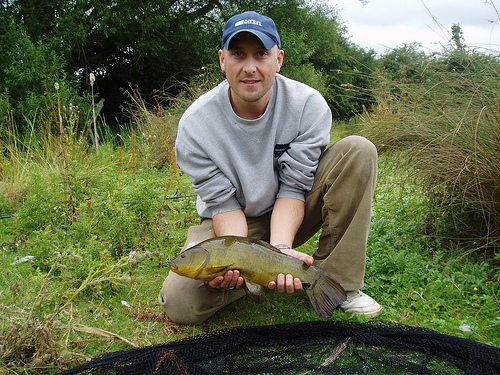

In [6]:
img = Image.fromarray(single_batch["image"][0])
img

In [7]:
single_batch.keys()

dict_keys(['image'])

### Applying Preprocessing Transforms to Images from Ray Dataset

This section defines and applies preprocessing steps to each image in the Ray Dataset:

- Loads the standard ImageNet normalisation and resizing transforms for ResNet-152.
- Combines the transforms with `ToTensor()` using `transforms.Compose`.
- Defines a `preprocess_image` function to:
  - Store the original image.
  - Apply the full transform pipeline, saving the result as `"transformed_image"`.
- Applies this function to every row in the dataset with `.map()`, creating a new dataset with both original and transformed images.
- Retrieves two samples as a batch and displays the available keys and the shape of the transformed images.

In [8]:
weights = ResNet152_Weights.IMAGENET1K_V1
imagenet_transforms = weights.transforms
transform = transforms.Compose([transforms.ToTensor(), imagenet_transforms()])

def preprocess_image(row: dict[str, np.ndarray]):
    return {
        "original_image": row["image"],
        "transformed_image": transform(row["image"]),
    }

In [9]:
transformed_ds = ds.map(preprocess_image)

In [10]:
two_batches = transformed_ds.take_batch(2)

2025-08-03 11:59:28,804	INFO logging.py:295 -- Registered dataset logger for dataset dataset_4_0
2025-08-03 11:59:28,812	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_4_0. Full logs are in /tmp/ray/session_2025-08-03_11-51-23_287332_2477/logs/ray-data
2025-08-03 11:59:28,813	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_4_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> TaskPoolMapOperator[Map(preprocess_image)] -> LimitOperator[limit=2]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- Map(preprocess_image) 3: 0.00 row [00:00, ? row/s]

- limit=2 4: 0.00 row [00:00, ? row/s]

(Map(preprocess_image) pid=3011, ip=100.118.46.34) /tmp/ray/session_2025-08-03_11-51-23_287332_2477/runtime_resources/pip/95827506fa75379904c3ce3b9ca4084a17838508/virtualenv/lib/python3.12/site-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
(Map(preprocess_image) pid=3011, ip=100.118.46.34)   img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
2025-08-03 11:59:36,673	INFO streaming_executor.py:231 -- ✔️  Dataset dataset_4_0 execution finished in 7.86 seconds


In [11]:
print(f"Batch is a dictionary with the following keys : {two_batches.keys()}")

Batch is a dictionary with the following keys : dict_keys(['original_image', 'transformed_image'])


In [12]:
two_batches["transformed_image"].shape

(2, 3, 224, 224)

### Batch Inference Class for Distributed Prediction with ResNet-152

This class encapsulates batch inference logic for ResNet-152 using PyTorch and Ray Data:

- **Initialisation**:  
  - Loads ResNet-152 with pretrained ImageNet weights.
  - Sets the model to evaluation mode for inference.
- **Call Method**:  
  - Accepts a batch of preprocessed images (as NumPy arrays).
  - Converts the batch to a PyTorch tensor and moves it to the appropriate device.
  - Performs inference in no-grad mode for efficiency.
  - Returns both the predicted labels and the original images.

> **Note:**  
> When used with Ray Data’s `.map_batches()` or `.map()`, an instance of this class is automatically created on each Ray worker (CPU or GPU).  
> Ray Data manages distributed execution and device placement—you do **not** need to use `@ray.remote` on this class.

In [13]:
class BatchInferenceResNet:
    def __init__(self):
        self.weights = ResNet152_Weights.IMAGENET1K_V1
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = resnet152(weights=self.weights).to(self.device)
        self.model.eval()

    def __call__(self, batch: dict[str, np.ndarray]):
        torch_batch = torch.from_numpy(batch["transformed_image"]).to(self.device)
        with torch.inference_mode():
            prediction = self.model(torch_batch)
            predicted_classes = prediction.argmax(dim=1).detach().cpu()
            predicted_labels = [
                self.weights.meta["categories"][i] for i in predicted_classes
            ]
            return {
                "predicted_label": predicted_labels,
                "original_image": batch["original_image"],
            }

In [16]:
predictions = transformed_ds.map_batches(
    BatchInferenceResNet,
    concurrency=1,  
    num_gpus=1,  
    batch_size=10,
)
prediction_batch = predictions.take_batch(5)

2025-08-03 12:00:23,230	INFO logging.py:295 -- Registered dataset logger for dataset dataset_8_0
2025-08-03 12:00:23,238	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_8_0. Full logs are in /tmp/ray/session_2025-08-03_11-51-23_287332_2477/logs/ray-data
2025-08-03 12:00:23,238	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_8_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> TaskPoolMapOperator[Map(preprocess_image)] -> ActorPoolMapOperator[MapBatches(BatchInferenceResNet)] -> LimitOperator[limit=5]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- Map(preprocess_image) 3: 0.00 row [00:00, ? row/s]

- MapBatches(BatchInferenceResNet) 4: 0.00 row [00:00, ? row/s]

- limit=5 5: 0.00 row [00:00, ? row/s]

(Map(preprocess_image) pid=3015, ip=100.118.46.34) /tmp/ray/session_2025-08-03_11-51-23_287332_2477/runtime_resources/pip/95827506fa75379904c3ce3b9ca4084a17838508/virtualenv/lib/python3.12/site-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
(Map(preprocess_image) pid=3015, ip=100.118.46.34)   img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
(Map(preprocess_image) pid=6320, ip=100.118.46.34) /tmp/ray/session_2025-08-03_11-51-23_287332_2477/runtime_resources/pip/95827506fa75379904c3ce3b9ca4084a17838508/virtualenv/lib/python3.12/site-packages/torchvision/tran

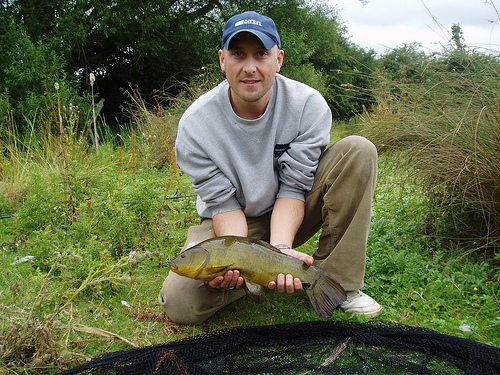

Label:  tench


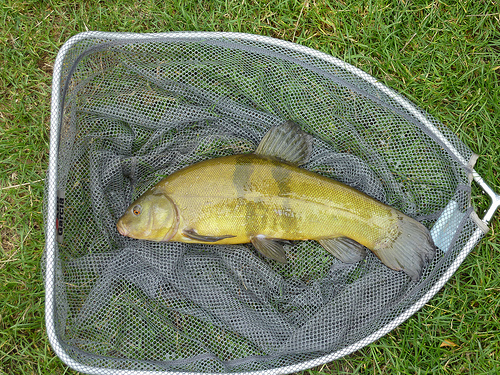

Label:  tench


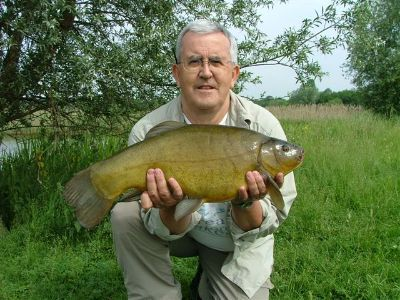

Label:  tench


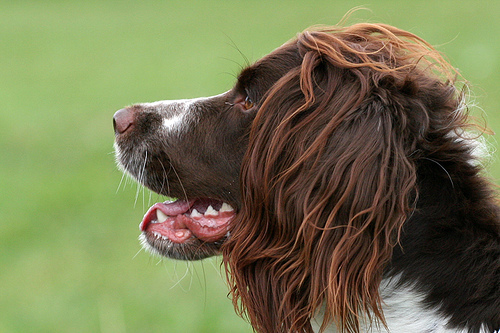

Label:  English springer


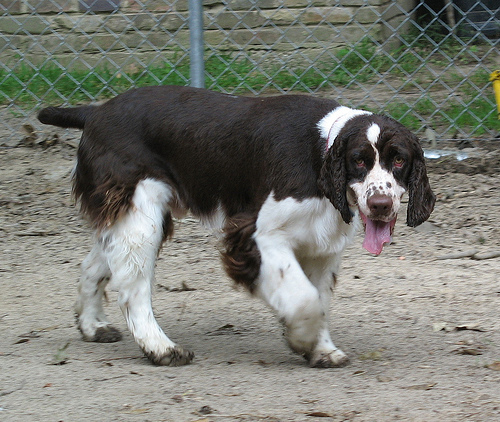

Label:  English springer


In [17]:
for image, prediction in zip(
    prediction_batch["original_image"], prediction_batch["predicted_label"]
):
    img = Image.fromarray(image)
    display(img)
    print("Label: ", prediction)